## Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import tensorflow as tf
import keras
import numpy.matlib
import mat73
import colorcet as cc

from numpy import asarray
from scipy import stats, signal, io
from scipy.ndimage import median_filter as medfilt

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.utils.extmath import randomized_svd as rsvd

from utils import tic, toc, hankel_matrix, scaler, legendre_polys, find_opt_lag, generate_color_gradient
from models import linear_regression, VAE

%matplotlib inline

2025-01-05 16:47:49.102472: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-05 16:47:49.231092: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-05 16:47:49.737157: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2025-01-05 16:47:49.737215: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such 

In [2]:
font = {'family' : 'arial',
        'size'   : 16}
plt.rc('font', **font)

In [3]:
def plot_allen(ax):
    allen_ccf = mat73.loadmat(data_dir + '/allen_ccf_overlay.mat')['allen_ccf']
    for i in range(len(allen_ccf)):
        temp1 = allen_ccf[i]
        ax.plot(temp1[:,0],temp1[:,1],'w',lw=.5)

## Load and preprocess data

In [4]:
def load_pupil(subj,filt=True):
    data_dict = mat73.loadmat(data_dir + '/' + str(subj) + '_pupil.mat')
    pupil = data_dict['pupil'].reshape(-1,1)
    pupil = medfilt(pupil,21)
    
    if filt:
        Fs = 20
        dt = 1/Fs
        sos = signal.butter(1, [.01,.2],btype = 'bandpass', output = 'sos', fs = Fs)
        pupil = signal.sosfiltfilt(sos, pupil, axis=0)
    
    pupil = pupil[1000:-800,:]
    
    pupil = StandardScaler(with_std=False).fit_transform(pupil)

    return pupil

In [5]:
def load_brain(subj,modality='jrgeco',filt=True):
    data_dict = mat73.loadmat(data_dir + '/' + str(subj) + '_' + modality + '.mat')
    brain = data_dict['data'][:,mask_long]

    if filt:
        Fs = 20
        dt = 1/Fs
        sos = signal.butter(1, [.01,.2],btype = 'bandpass', output = 'sos', fs = Fs)
        brain = signal.sosfiltfilt(sos, brain, axis=0)
        
    brain = brain[1000:-800,:]
    
    brain = StandardScaler(with_std=False).fit_transform(brain)

    return brain

In [6]:
data_dir = '/home/ryanr/widefield'
outdir = '/home/ryanr/Allen/arousal_final/model_predictions'
figdir = '/home/ryanr/Allen/arousal_final/figs'
mask = io.loadmat(data_dir+'/newmask.mat')
mask = mask["newmask"]
mask.dtype = bool
mask_long = mask.reshape(16384,order='F')
allen_ccf = mat73.loadmat(data_dir + '/allen_ccf_overlay.mat')['allen_ccf']

In [7]:
from numpy.random import seed
seed(1)

# Analysis

In [8]:
## Set modeling parameters

subjects = [4,5,6,7,8,9,10]
delay = 1 # implement delay embedding? 0 or 1
nonlinear = 1 # use nonlinear mappings (VAE) (as opposed to linear regression) ? 0 or 1
Fs = 20 # sampling frequency
dt = 1/Fs
stackmax = 100 # Hankel row dimension (i.e., number of time shifts)
spacing = 3 # number of samples separating each row
r = 10 # number of modes of the Hankel matrix to keep (used for projection onto top r Legendre polynomials)
z_n = 4 # number of latent dimensions used for VAE
num_epochs = 200 # number of training epochs
lr = .001 # learning rate
beta = .1 # beta weight for KL loss in VAE training
anneal_step = 2000 # determines rate at which KL loss is increased during training
pretrained_enc = [] # pretrained encoder

In [9]:
## Create group files

xtrains = []
pupils = []
ytrains = []
yscales = []
lags = []

modality='jrgeco'

for s in range(len(subjects)):
    
    tic()
    
    subj = subjects[s]
    
    # Load data
    pupil = load_pupil(subj)
    brain = load_brain(subj,modality)
    
    # Compute lags for later
    lag_range = 5 # range over which to look for optimal lag between pupil and brain cross-correlation (in seconds)
    lag_range = int(lag_range/dt)
    lag,_,_ = find_opt_lag(pupil,np.mean(brain,axis=1),lag_range)
    lags.append(lag)
          
    ## Time delay embedding
    polys = legendre_polys(r, stackmax)
    Hp = hankel_matrix(pupil.T,stackmax,spacing)
    xtrain = Hp.T@polys
    xtrain = np.concatenate((xtrain,Hp.T[:,-1:]),axis=1)
    ytrain = brain[spacing*(stackmax-1):,:]
        
    xtrain,_ = scaler(xtrain)
    ytrain, scale_y = scaler(ytrain)
    
    xtrains.append(xtrain)
    ytrains.append(ytrain)
    yscales.append(scale_y)
    
    toc()


Elapsed time is 8.31528615951538 seconds.
Elapsed time is 8.676857233047485 seconds.
Elapsed time is 8.527291297912598 seconds.
Elapsed time is 8.55003833770752 seconds.
Elapsed time is 8.649485349655151 seconds.
Elapsed time is 8.774532079696655 seconds.
Elapsed time is 8.454079866409302 seconds.


In [10]:
# Leave-one-out crossval

num_PCs = 10
modality = 'jrgeco'

num_shuffles = len(subjects)
null_scores = np.zeros((num_shuffles,len(subjects)))

for s in range(len(subjects)):
    
    tic()
    
    # Apply the median lag adjustment to all mice
    lag = int(np.median(lags[:s] + lags[s+1:]))

    xtrains_aligned = xtrains.copy()
    ytrains_aligned = ytrains.copy()

    for ss in range(len(xtrains)):
        xtrains_aligned[ss] = xtrains_aligned[ss][lag:,:]
        ytrains_aligned[ss] = ytrains_aligned[ss][:-lag,:]

    train_x = np.concatenate(xtrains_aligned[:s] + xtrains_aligned[s+1:], axis=0)
    train_y = np.concatenate(ytrains_aligned[:s] + ytrains_aligned[s+1:], axis=0)

    test_x = xtrains_aligned[s]

    # Project to top group PCs for efficient training
    u,sigma,vh = rsvd(train_y, n_components=num_PCs)

    train_y = train_y@vh.T[:,:num_PCs]
    
    # Preprocessing
    train_x_sc, scale_x = scaler(train_x)
    train_y_sc, scale_y = scaler(train_y)
    
    # Train model
    r_squared, model, encoder, decoder = VAE(train_x_sc, train_y_sc, latent_dim=z_n, beta=beta,
                                            num_epochs=num_epochs, anneal_step=anneal_step, lr=lr, verbose=False)
    
    test_y = load_brain(subjects[s])[spacing*(stackmax-1):,:][:-lag,:]
    
    for k in range(len(subjects)):
        
        print(f'Fold {s} iter {k+1}/{num_shuffles}')
        
        test_x = xtrains_aligned[k]

        # Test model    
        test_x_sc,_ = scaler(test_x, scale_x)

        test_y_hat_sc = model.predict(test_x_sc)
        test_y_hat = scale_y.inverse_transform(test_y_hat_sc)
        test_y_hat = yscales[s].inverse_transform(test_y_hat@vh[:num_PCs,:]) # project back to brain space

        null_scores[k,s] = r2_score(test_y,test_y_hat,multioutput='variance_weighted')
        
    toc()

2025-01-05 16:49:00.132304: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-05 16:49:02.026414: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9627 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:19:00.0, compute capability: 7.5
2025-01-05 16:49:02.027175: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 9627 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:1a:00.0, compute capability: 7.5
2025-01-05 16:49:02.027759: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/repli

Fold 0 iter 1/7
Fold 0 iter 2/7
Fold 0 iter 3/7
Fold 0 iter 4/7
Fold 0 iter 5/7
Fold 0 iter 6/7
Fold 0 iter 7/7
Elapsed time is 91.28619122505188 seconds.
Fold 1 iter 1/7
Fold 1 iter 2/7
Fold 1 iter 3/7
Fold 1 iter 4/7
Fold 1 iter 5/7
Fold 1 iter 6/7
Fold 1 iter 7/7
Elapsed time is 87.79693412780762 seconds.
Fold 2 iter 1/7
Fold 2 iter 2/7
Fold 2 iter 3/7
Fold 2 iter 4/7
Fold 2 iter 5/7
Fold 2 iter 6/7
Fold 2 iter 7/7
Elapsed time is 88.44853901863098 seconds.
Fold 3 iter 1/7
Fold 3 iter 2/7
Fold 3 iter 3/7
Fold 3 iter 4/7
Fold 3 iter 5/7
Fold 3 iter 6/7
Fold 3 iter 7/7
Elapsed time is 87.74692463874817 seconds.
Fold 4 iter 1/7
Fold 4 iter 2/7
Fold 4 iter 3/7
Fold 4 iter 4/7
Fold 4 iter 5/7
Fold 4 iter 6/7
Fold 4 iter 7/7
Elapsed time is 88.48730707168579 seconds.
Fold 5 iter 1/7
Fold 5 iter 2/7
Fold 5 iter 3/7
Fold 5 iter 4/7
Fold 5 iter 5/7
Fold 5 iter 6/7
Fold 5 iter 7/7
Elapsed time is 88.4955747127533 seconds.
Fold 6 iter 1/7
Fold 6 iter 2/7
Fold 6 iter 3/7
Fold 6 iter 4/7
Fold 6 

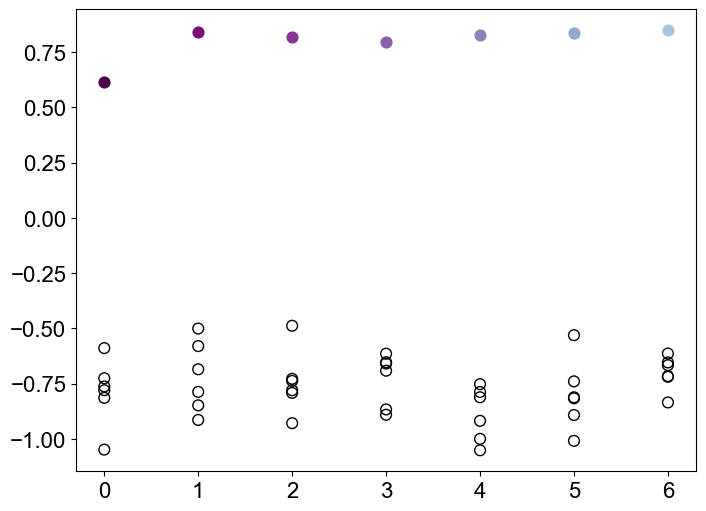

<Figure size 640x480 with 0 Axes>

In [11]:
line_colors = generate_color_gradient(len(subjects)+3,modality)

fig, ax = plt.subplots(figsize=(8,6))

for i in range(len(subjects)):
    for j in range(len(subjects)):
        if i==j:
            plt.scatter(i, null_scores[i,j], 60, color=line_colors[i], label=f'Mouse {i+1}')
        else:
            plt.scatter(i, null_scores[i,j], 60, facecolors='none',edgecolors='k')

ax.set_xticks([])
#ax.set_ylim([-2,1])
ax.set_ylabel('$R^2$', fontsize=20)

plt.savefig(figdir + '/shuffle_LOO.pdf', dpi=300, transparent=True)

plt.show()